<a href="https://colab.research.google.com/github/bonksl/Unit6/blob/master/Jewelry_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Copying test pictures from drive to local drive
!cp -r /content/drive/My\ Drive/Jewelry /content/Jewelry\ Recognition/

In [ ]:
!ls

 drive	'Jewelry Recognition'   sample_data


In [ ]:
pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("Jewelry Recognition/jewelry"))

# Any results you write to the current directory are saved as output.
import gc
gc.collect()

['earrings', 'jewelry', 'necklaces', 'rings', 'bracelets']


0

In [ ]:
# !pip install pretrainedmodels

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai==1.0.57
import fastai

from fastai import *
from fastai.vision import *

# from torchvision.models import *
# import pretrainedmodels

!pip install utils
from utils import *
import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [ ]:
path = 'Jewelry Recognition/jewelry'

In [ ]:
tfms = get_transforms(max_rotate= 10.,max_zoom=1., max_lighting=0.20, do_flip=False,
                      max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7), contrast(scale=(0.5, 2), p=0.7),
                                              crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
                                              rand_zoom(scale=(1.,1.5)), rand_crop(),
                                              perspective_warp(magnitude=(-0.1,0.1)),
                                              symmetric_warp(magnitude=(-0.1,0.1)) ])

src = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2, seed=42)
        .label_from_folder())

In [ ]:
import warnings
warnings.simplefilter("ignore")
data = (src.transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128)
        .databunch(bs=64, num_workers=0)
        .normalize(imagenet_stats))

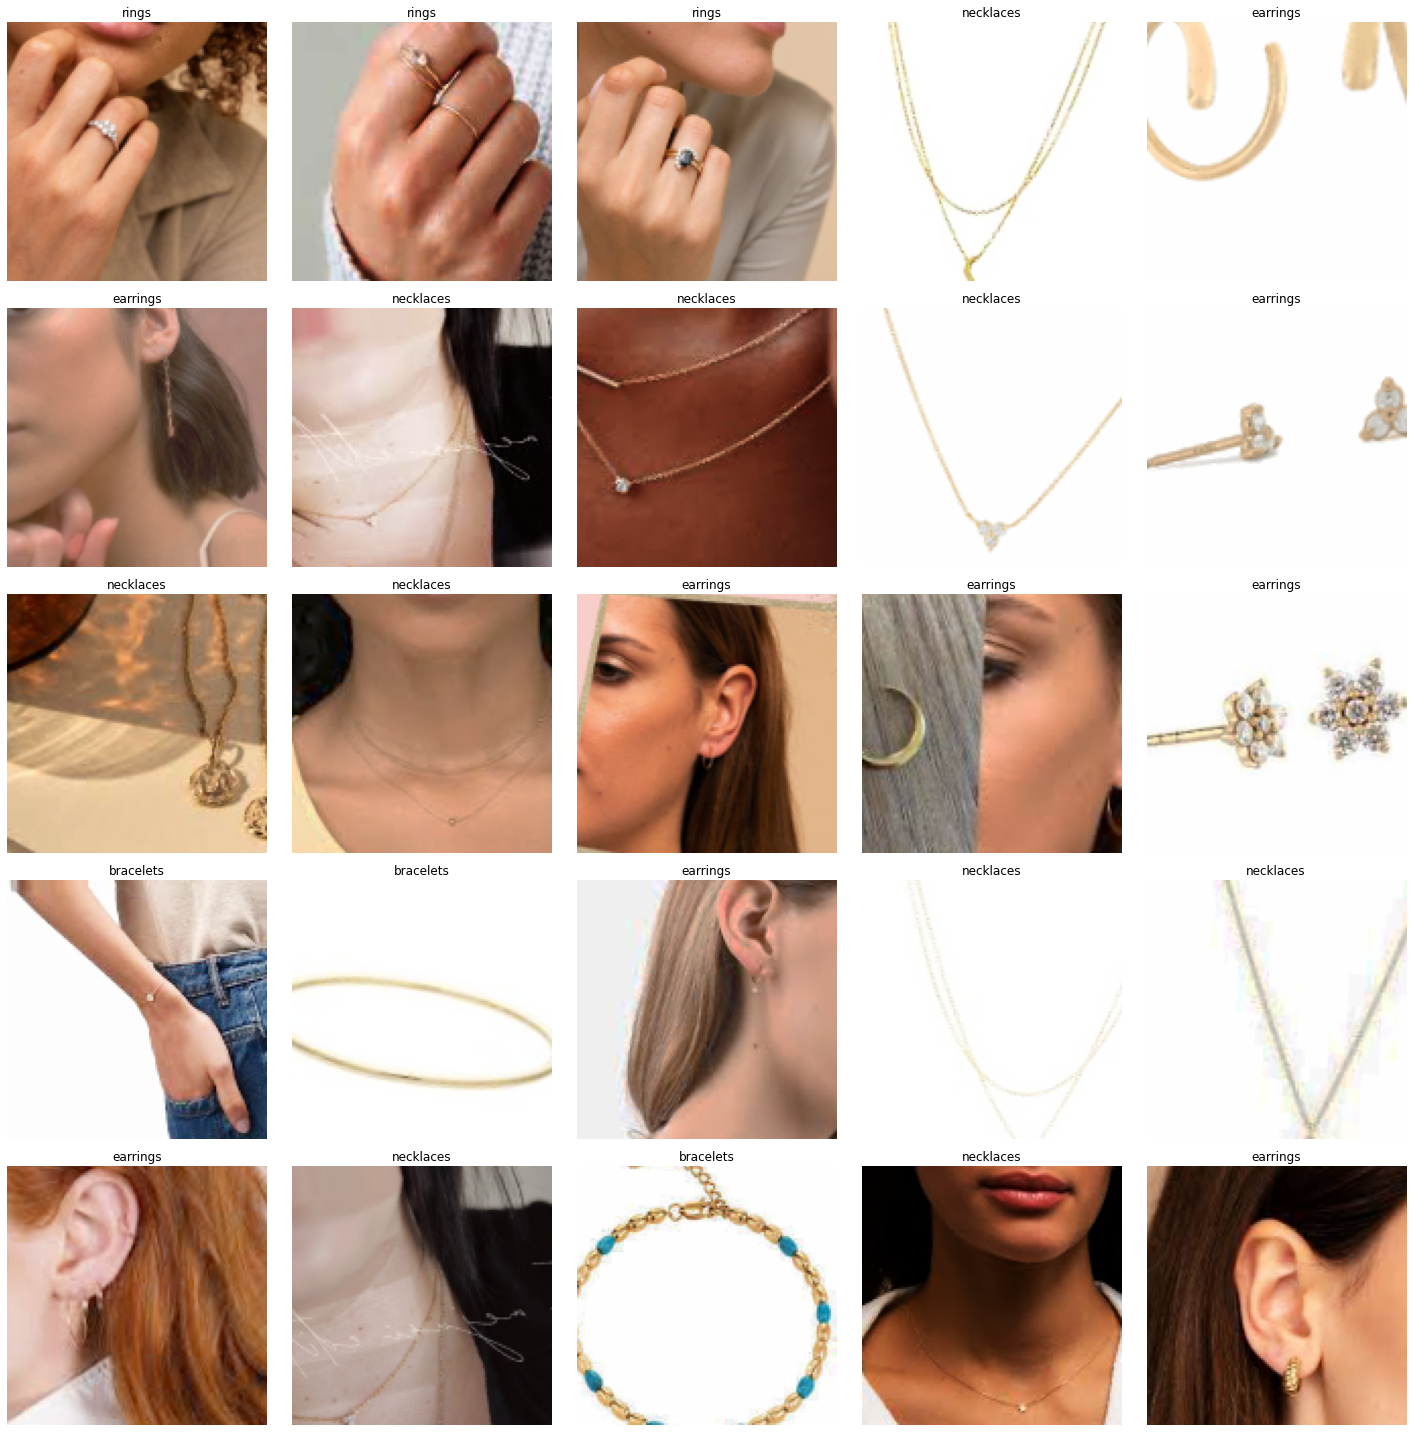

In [ ]:
data.show_batch()

In [ ]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['bracelets', 'earrings', 'necklaces', 'rings']


# CNN Learner - Model - ResNet50

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate]).mixup()

In [ ]:
#learn.fine_tune(4)

AttributeError: ignored

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)

# losses,idxs = interp.top_losses()

# len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
# interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [ ]:
# interp.plot_top_losses(15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 1.00E-02


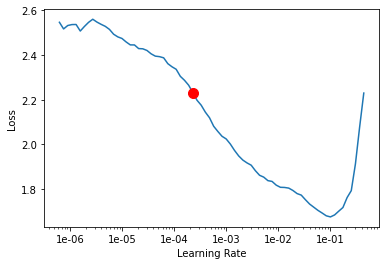

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr=1e-3
# learn.fit_one_cycle(3, max_lr=slice(1e-2), wd = (1e-6, 1e-4, 1e-2), pct_start=0.5)
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-3), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.998700,0.704792,0.800000,0.200000,00:19
1,1.625847,0.423346,0.880000,0.120000,00:19
2,1.468180,0.314290,0.902857,0.097143,00:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 4.79E-05


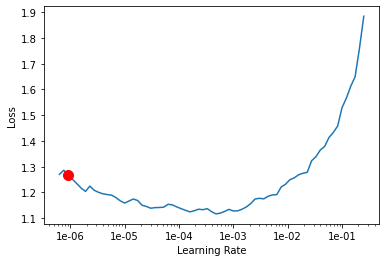

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# learn.fit_one_cycle(2, max_lr = slice(5e-6,lr/5), wd=(1e-6, 1e-4, 1e-2), pct_start=0.5)
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-5), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.134475,0.310112,0.897143,0.102857,00:19
1,1.146423,0.290808,0.914286,0.085714,00:20
2,1.174084,0.281171,0.920000,0.080000,00:20


# Progressive Image Resizing

In [ ]:
data_big = (src.transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=256)
        .databunch(bs=64, num_workers=0)
        .normalize(imagenet_stats))

learn.data = data_big

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 9.12E-08


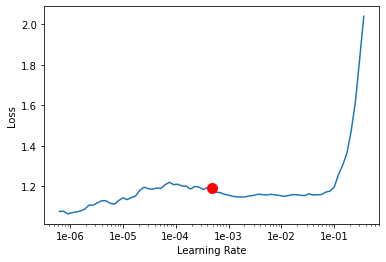

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 1e-5
#learn.fit_one_cycle(2, max_lr=slice(lr), wd=(1e-6, 1e-4, 1e-2), pct_start=0.5)
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-3), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.285200,0.273738,0.891429,0.108571,00:33
1,1.197197,0.665205,0.840000,0.160000,00:31
2,1.174676,0.293380,0.885714,0.114286,00:32


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.92E-05


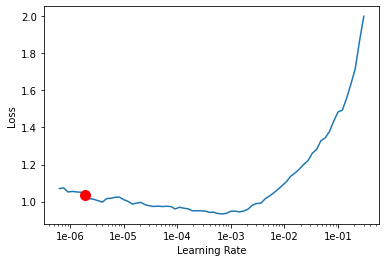

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4), wd=(1e-6, 1e-4, 1e-2), pct_start=0.5)
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-5), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.043750,0.295937,0.885714,0.114286,00:34
1,1.023415,0.293706,0.885714,0.114286,00:34
2,1.023417,0.293725,0.874286,0.125714,00:34


# Results of the model

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_big.valid_ds)==len(losses)==len(idxs)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


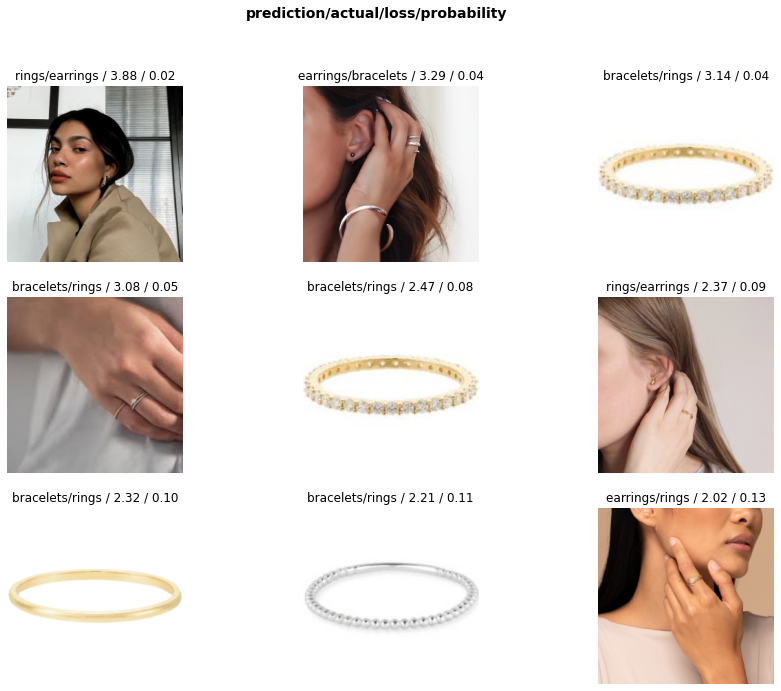

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

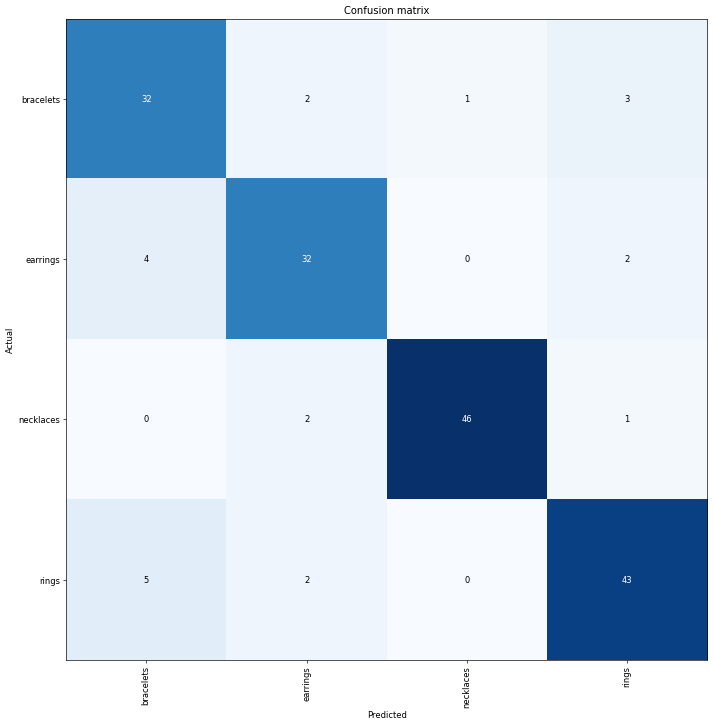

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('rings', 'bracelets', 5),
 ('earrings', 'bracelets', 4),
 ('bracelets', 'rings', 3),
 ('bracelets', 'earrings', 2),
 ('earrings', 'rings', 2),
 ('necklaces', 'earrings', 2),
 ('rings', 'earrings', 2)]

In [ ]:
learn.save('final_model')

In [ ]:
learn.model

## Turning your model into an online application

### Using the model for inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
#is the program you use to predict
# learn_inf = load_learner('final_model')
learn_inf = learn.load('final_model')

In [ ]:
!ls

 drive	'Jewelry Recognition'   sample_data


In [ ]:
# learn_inf.predict('Jewelry Recognition/jewelry/bracelets/428 (1).jpg')

In [ ]:
# learn_inf.dls.vocab

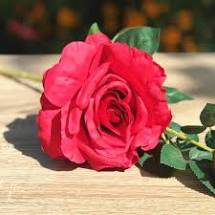

In [ ]:
#Test image

img = open_image('Jewelry Recognition/jewelry/models/rose123.jpeg')
img

In [ ]:
# Get the predicted class, the index and the outputs
predicted_class, predicted_index, outputs = learn.predict(img)
predicted_class

Category earrings

In [ ]:
predicted_index

tensor(1)

In [ ]:
outputs

tensor([0.0968, 0.3836, 0.2215, 0.2981])

# Fastai Hooks

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
# Second last layer of the model
learn.model[1][4]

Linear(in_features=4096, out_features=512, bias=True)

In [ ]:
sf = SaveFeatures(learn.model[1][4])

In [ ]:
_= learn.get_preds(data_big.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [ ]:
len(sf.features)

878

In [ ]:
img_path = [str(x) for x in (list(data_big.train_ds.items) +list(data_big.valid_ds.items))]
label = [data_big.classes[x] for x in (list(data_big.train_ds.y.items) +list(data_big.valid_ds.y.items))]
label_id = [x for x in (list(data_big.train_ds.y.items) +list(data_big.valid_ds.y.items))]

In [ ]:
#img_path = 

In [ ]:
len(img_path), len(label), len(label_id)

(878, 878, 878)

In [ ]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
df_new

,img_path,label,label_id
0,Jewelry Recognition/jewelry/earrings/images (5...,earrings,1
1,Jewelry Recognition/jewelry/earrings/images (6...,earrings,1
2,Jewelry Recognition/jewelry/earrings/881c4bb35...,earrings,1
3,Jewelry Recognition/jewelry/earrings/images (4...,earrings,1
4,Jewelry Recognition/jewelry/earrings/image (20...,earrings,1
...,...,...,...
873,Jewelry Recognition/jewelry/bracelets/images (...,bracelets,0
874,Jewelry Recognition/jewelry/rings/FASHION_MINI...,rings,3
875,Jewelry Recognition/jewelry/necklaces/images (...,necklaces,2
876,Jewelry Recognition/jewelry/rings/thekit2019-m...,rings,3


In [ ]:
array = np.array(sf.features)

In [ ]:
x=array.tolist()

In [ ]:
df_new['img_repr'] = x

In [ ]:
df_new.head()

,img_path,label,label_id,img_repr
0,Jewelry Recognition/jewelry/earrings/images (5...,earrings,1,"[3.480440855026245, -2.775660514831543, 0.6158..."
1,Jewelry Recognition/jewelry/earrings/images (6...,earrings,1,"[1.2666617631912231, -0.7908381223678589, -0.1..."
2,Jewelry Recognition/jewelry/earrings/881c4bb35...,earrings,1,"[0.7686582207679749, -1.0660526752471924, -0.8..."
3,Jewelry Recognition/jewelry/earrings/images (4...,earrings,1,"[2.1947085857391357, -2.673952102661133, -1.15..."
4,Jewelry Recognition/jewelry/earrings/image (20...,earrings,1,"[-0.11675865948200226, -1.3659377098083496, 2...."


In [ ]:
df_new.shape

(878, 4)

# Image Similarity using Annoy

In [ ]:
pip install annoy

     |████████████████████████████████| 645kB 4.7MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297323 sha256=81bdb63893d62721cae63ba98aba84875e7f96bbc5834123161866cf82a17e69
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex

In [ ]:
df_new['img_repr'][0]

[3.480440855026245,
 -2.775660514831543,
 0.6158832311630249,
 2.927834987640381,
 3.469890594482422,
 3.4682159423828125,
 -0.6173727512359619,
 2.251801013946533,
 3.1205196380615234,
 -2.2837886810302734,
 0.5852106809616089,
 3.540642738342285,
 3.9119510650634766,
 -0.9549224972724915,
 4.551700115203857,
 0.09994840621948242,
 -1.733705997467041,
 -3.2445590496063232,
 2.551100015640259,
 7.071152687072754,
 3.3286495208740234,
 0.9012773633003235,
 1.4885830879211426,
 0.02345956861972809,
 -2.4348301887512207,
 1.0443357229232788,
 -2.237675666809082,
 -2.0183067321777344,
 0.1014937162399292,
 1.3987137079238892,
 -3.244645357131958,
 1.7318869829177856,
 -2.868481159210205,
 -2.0414938926696777,
 -1.7113935947418213,
 1.9197006225585938,
 1.3400243520736694,
 1.0343937873840332,
 -3.0548911094665527,
 -0.8042207956314087,
 -0.9776020646095276,
 -3.1070563793182373,
 -0.6749377250671387,
 -0.6512059569358826,
 -1.0171371698379517,
 1.0780168771743774,
 -0.23208022117614746,
 -

In [ ]:
f = len(df_new['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

In [ ]:
f

512

In [ ]:
t

In [ ]:
ntree = 50

for i, vector in enumerate(df_new['img_repr']):
    t.add_item(i, vector)
_  = t.build(ntree)

In [ ]:
import time
def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = df_new.iloc[img_index, [0, 3, 1]]
    similar_img_ids = t.get_nns_by_item(img_index, 8)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [ ]:
get_similar_images_annoy(0)

0.8919239044189453 ms


('Jewelry Recognition/jewelry/earrings/images (51).jpeg',
 'earrings',
                                               img_path  ...                                           img_repr
 0    Jewelry Recognition/jewelry/earrings/images (5...  ...  [3.480440855026245, -2.775660514831543, 0.6158...
 31   Jewelry Recognition/jewelry/earrings/images (2...  ...  [2.3846170902252197, -2.1388487815856934, 0.93...
 61   Jewelry Recognition/jewelry/earrings/images (4...  ...  [3.219489097595215, -4.100240230560303, -1.219...
 115  Jewelry Recognition/jewelry/earrings/images (2...  ...  [3.936735153198242, -3.3795790672302246, -0.27...
 113  Jewelry Recognition/jewelry/earrings/images (2...  ...  [2.5636935234069824, -6.59188985824585, 1.0545...
 84   Jewelry Recognition/jewelry/earrings/images (5...  ...  [2.603804111480713, -4.906100273132324, 0.8808...
 38   Jewelry Recognition/jewelry/earrings/images (4...  ...  [1.888993740081787, -5.392519474029541, -1.315...
 19   Jewelry Recognition/jewelry

In [ ]:
base_image, base_label, similar_images_df = get_similar_images_annoy(0)

0.7998943328857422 ms


earrings


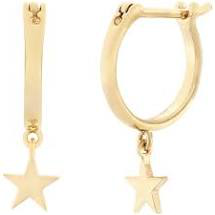

In [ ]:
print(base_label)
open_image(base_image)

In [ ]:
similar_images_df

,img_path,label,label_id,img_repr
0,Jewelry Recognition/jewelry/earrings/images (5...,earrings,1,"[3.480440855026245, -2.775660514831543, 0.6158..."
31,Jewelry Recognition/jewelry/earrings/images (2...,earrings,1,"[2.3846170902252197, -2.1388487815856934, 0.93..."
61,Jewelry Recognition/jewelry/earrings/images (4...,earrings,1,"[3.219489097595215, -4.100240230560303, -1.219..."
115,Jewelry Recognition/jewelry/earrings/images (2...,earrings,1,"[3.936735153198242, -3.3795790672302246, -0.27..."
113,Jewelry Recognition/jewelry/earrings/images (2...,earrings,1,"[2.5636935234069824, -6.59188985824585, 1.0545..."
84,Jewelry Recognition/jewelry/earrings/images (5...,earrings,1,"[2.603804111480713, -4.906100273132324, 0.8808..."
38,Jewelry Recognition/jewelry/earrings/images (4...,earrings,1,"[1.888993740081787, -5.392519474029541, -1.315..."
19,Jewelry Recognition/jewelry/earrings/images (2...,earrings,1,"[0.5763552188873291, -5.669137001037598, -0.85..."


In [ ]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories)

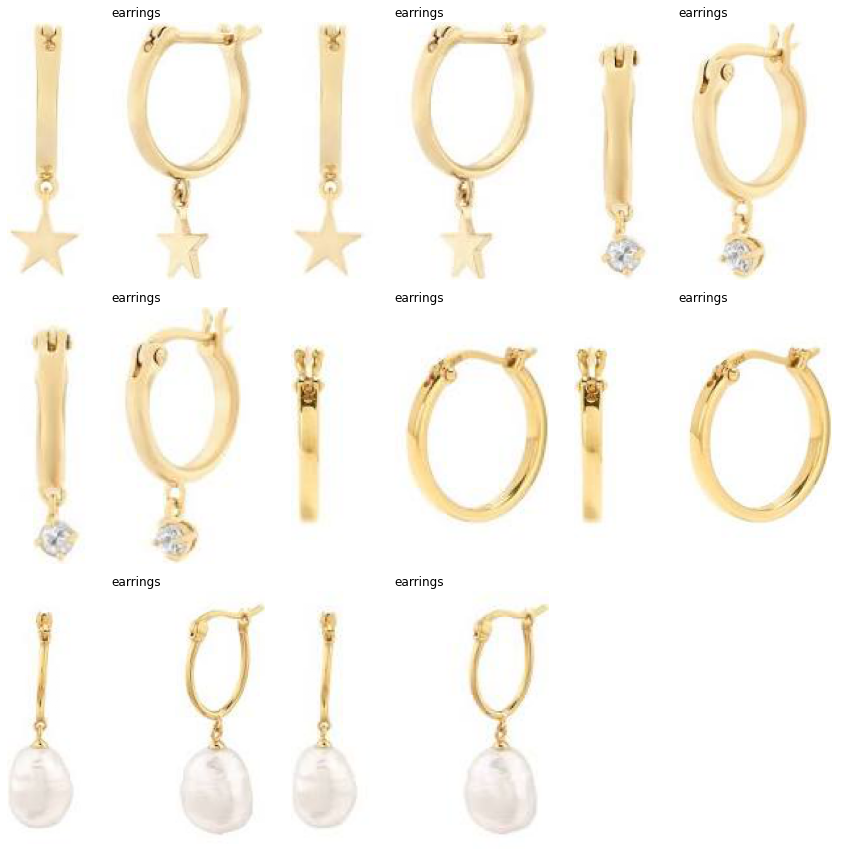

In [ ]:
show_similar_images(similar_images_df)

# Image similarity using Cosine Similarity


In [ ]:
from scipy.spatial.distance import cosine

def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label  = df_new.iloc[img_index, [0, 3, 1]]
    cosine_similarity = 1 - df_new['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [ ]:
base_image, base_label, similar_images_df = get_similar_images(1)

0.10111761093139648 secs


In [ ]:
get_similar_images(1)

0.0748300552368164 secs


('Jewelry Recognition/jewelry/earrings/images (6).png',
 'earrings',
                                               img_path  ...                                           img_repr
 732  Jewelry Recognition/jewelry/earrings/images (1...  ...  [0.5391775369644165, -0.5679493546485901, -0.6...
 159  Jewelry Recognition/jewelry/earrings/images (5...  ...  [1.641875147819519, -4.263139724731445, -0.840...
 833  Jewelry Recognition/jewelry/rings/images (71)....  ...  [0.7115828990936279, -3.0153627395629883, -0.8...
 9    Jewelry Recognition/jewelry/earrings/images (9...  ...  [1.3136637210845947, -2.129167318344116, 1.010...
 21   Jewelry Recognition/jewelry/earrings/images (2...  ...  [1.430618405342102, -4.0851593017578125, -1.07...
 748  Jewelry Recognition/jewelry/earrings/image (1)...  ...  [1.9903247356414795, -4.000182628631592, -0.11...
 50   Jewelry Recognition/jewelry/earrings/images (4...  ...  [1.2881566286087036, -1.5014545917510986, 1.42...
 57     Jewelry Recognition/jewelry

earrings
Jewelry Recognition/jewelry/earrings/images (6).png


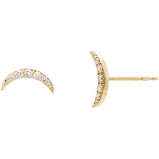

In [ ]:
print(base_label)
print(base_image)
open_image(base_image)

In [ ]:
similar_images_df

,img_path,label,label_id,img_repr
732,Jewelry Recognition/jewelry/earrings/images (1...,earrings,1,"[0.5391775369644165, -0.5679493546485901, -0.6..."
159,Jewelry Recognition/jewelry/earrings/images (5...,earrings,1,"[1.641875147819519, -4.263139724731445, -0.840..."
833,Jewelry Recognition/jewelry/rings/images (71)....,rings,3,"[0.7115828990936279, -3.0153627395629883, -0.8..."
9,Jewelry Recognition/jewelry/earrings/images (9...,earrings,1,"[1.3136637210845947, -2.129167318344116, 1.010..."
21,Jewelry Recognition/jewelry/earrings/images (2...,earrings,1,"[1.430618405342102, -4.0851593017578125, -1.07..."
748,Jewelry Recognition/jewelry/earrings/image (1)...,earrings,1,"[1.9903247356414795, -4.000182628631592, -0.11..."
50,Jewelry Recognition/jewelry/earrings/images (4...,earrings,1,"[1.2881566286087036, -1.5014545917510986, 1.42..."
57,Jewelry Recognition/jewelry/earrings/images.png,earrings,1,"[4.822629928588867, -2.04422664642334, 1.85877..."
804,Jewelry Recognition/jewelry/rings/images (31)....,rings,3,"[1.5917845964431763, -3.829782009124756, -0.78..."
815,Jewelry Recognition/jewelry/rings/images (22)....,rings,3,"[-1.497281789779663, 0.11028903722763062, 0.11..."


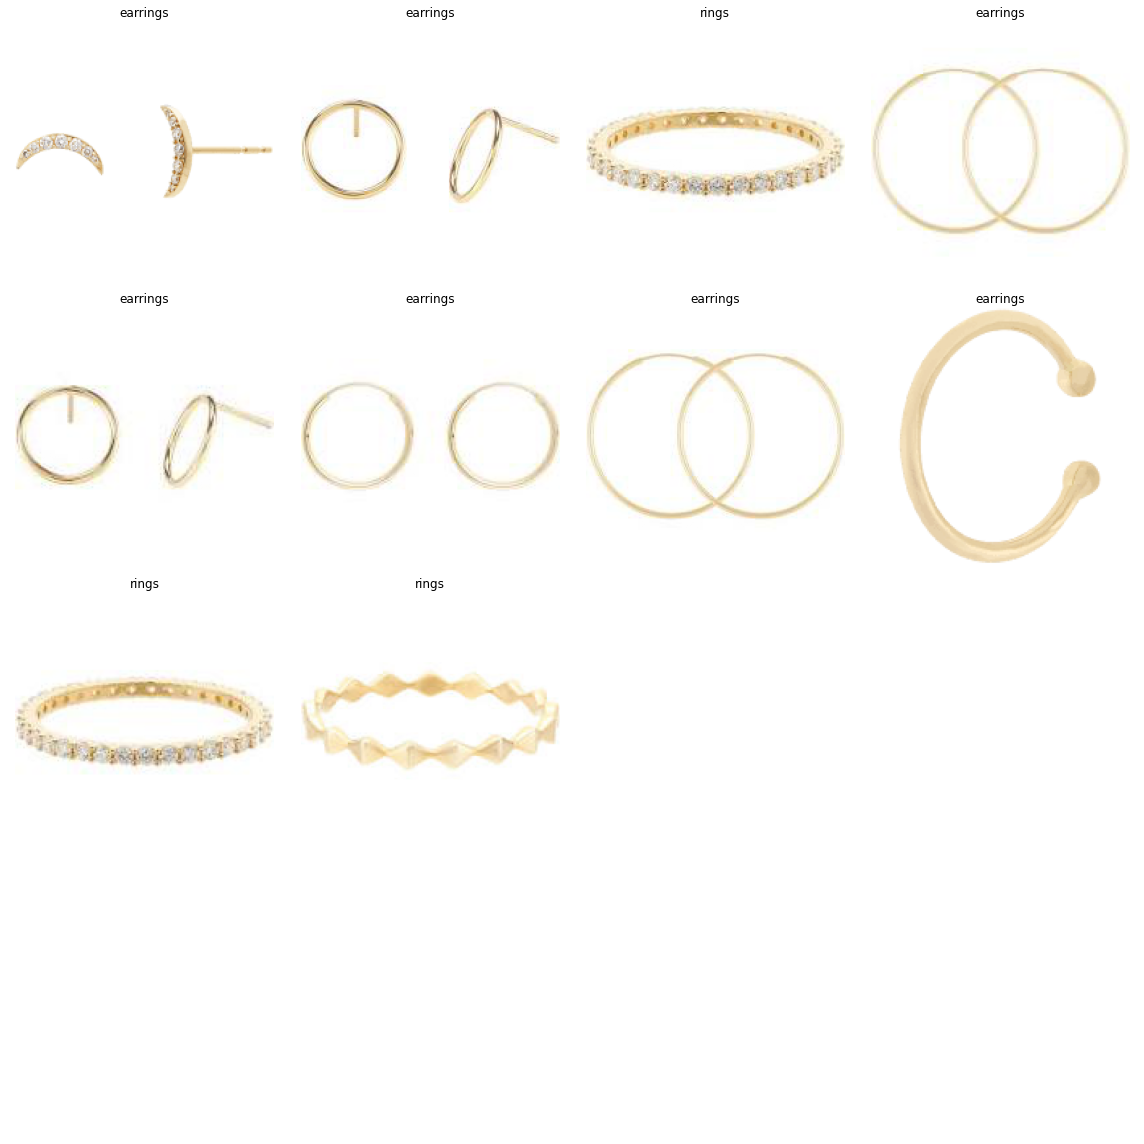

In [ ]:
show_similar_images(similar_images_df)

# T-SNE

In [ ]:
from sklearn.manifold import TSNE

img_repr_matrix = [list(x) for x in df_new['img_repr'].values]
tsne = TSNE(n_components=3, verbose=10, init='pca', perplexity=30, n_iter=500, n_iter_without_progress=100)
tsne_results_3 = tsne.fit_transform(img_repr_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 957 samples in 0.033s...
[t-SNE] Computed neighbors for 957 samples in 0.661s...
[t-SNE] Computed conditional probabilities for sample 957 / 957
[t-SNE] Mean sigma: 37.074108
[t-SNE] Computed conditional probabilities in 0.097s
[t-SNE] Iteration 50: error = 75.5713425, gradient norm = 0.0213909 (50 iterations in 2.586s)
[t-SNE] Iteration 100: error = 96.3320618, gradient norm = 0.0431273 (50 iterations in 2.159s)
[t-SNE] Iteration 150: error = 97.8358612, gradient norm = 0.0473694 (50 iterations in 1.850s)
[t-SNE] Iteration 200: error = 97.5356369, gradient norm = 0.0343350 (50 iterations in 1.703s)
[t-SNE] Iteration 250: error = 96.7590408, gradient norm = 0.0339834 (50 iterations in 1.521s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.759041
[t-SNE] Iteration 300: error = 1.4733144, gradient norm = 0.0003293 (50 iterations in 2.115s)
[t-SNE] Iteration 350: error = 1.2792252, gradient norm = 0.0001242 

In [ ]:
df_new['tsne1'] = tsne_results_3[:,0]
df_new['tsne2'] = tsne_results_3[:,1]
df_new['tsne3'] = tsne_results_3[:,2]

In [ ]:
df_new.to_parquet('similar_images')


In [ ]:
pip install plotly_express

In [ ]:
import plotly_express as px
px.scatter_3d(df_new, x='tsne1', y='tsne2', z='tsne3', color='label')